# Pricing Exploratory Data Analysis

### Client request
Here is an excel file with 2 data sets. This is actual data.

The first data set is a standard correlation where the baseline and benchmark show a strong correlation according to my simple method
The second data set is an example where the correlation is good, until it is not for a period of 12 months or so, before the lines come back together. This was caused by a disruption by a fire at one supplier after which capacity was limited and the link between market pricing and cost driver pricing was no longer relevant

Some notes <br>
The 2 data sets which I am running my analysis on are shaded in blue. 
I have added the formulas so you can see how they are calculated from the underlying data sets. 
Some of the data preparation (averaging, adjusting for lag, FX conversion) is not visible in this file but it is not so relevant for the statistics.

__I would love to know if there is a better way to:__
- Understand or analyse the correlation between the 2 main lines
- Understand the correlation between the base line and each of the individual cost drivers so that the cost drivers could be ranked in terms of relevance in some way

I am available to answer any questions about this data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from jmspack.utils import (apply_scaling,
                          JmsColors)
# from jmspack.ml_utils import plot_confusion_matrix
from jmspack.frequentist_statistics import correlation_analysis

from dtw import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import shap

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
shap.initjs()

In [3]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [4]:
df_choice = "unclear_result"
if df_choice == "clear_result":
    df = (pd.read_excel("data/Input for statistics v1.xlsx", sheet_name=0)
        .assign(**{"Date": lambda x: pd.to_datetime(x["Date"]).dt.date})
        .dropna()
        .set_index("Date")
    )
else:
    df = (pd.read_excel("data/Input for statistics v1.xlsx", sheet_name=1)
        .assign(**{"Date": lambda x: pd.to_datetime(x["Date"]).dt.date})
        .dropna()
        .set_index("Date")
        )

In [5]:
df.head()

,Baseline,Weighted benchmark,Benchmark index,Chlorine,Benzene,Aluminium
Date,,,,,,
2017-04-01,1.068,1.06685,1.121545,1.099,1.013,1.239
2017-05-01,1.087,1.07005,1.127364,1.099,1.006,1.265
2017-06-01,1.087,1.07815,1.142091,1.099,1.087,1.265
2017-07-01,1.087,1.07765,1.141182,1.093,1.142,1.237
2017-08-01,1.087,1.07565,1.137545,1.069,1.188,1.241


In [6]:
target = "Baseline"

In [7]:
df.describe()

,Baseline,Weighted benchmark,Benchmark index,Chlorine,Benzene,Aluminium
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.070700,1.032053,1.058279,1.031233,1.062683,1.109433
std,0.043434,0.038837,0.070612,0.084605,0.093602,0.102285
min,0.997000,0.952650,0.913909,0.894000,0.787000,0.863000
25%,1.039250,1.006787,1.012341,0.985000,1.004500,1.037500
50%,1.066500,1.038575,1.070136,1.029000,1.088500,1.135500
75%,1.087000,1.050563,1.091932,1.064000,1.121750,1.194000
max,1.160000,1.143200,1.260364,1.371000,1.216000,1.265000


## Plot the amount of rows in each side of the target

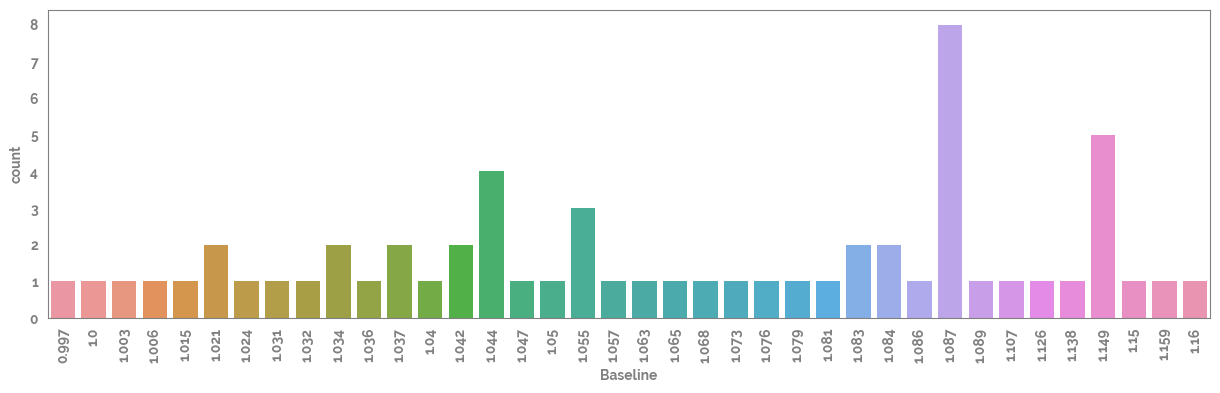

In [8]:
_ = plt.figure(figsize=(15, 4))
_ = sns.countplot(x=df[target])
_ = plt.xticks(rotation=90)

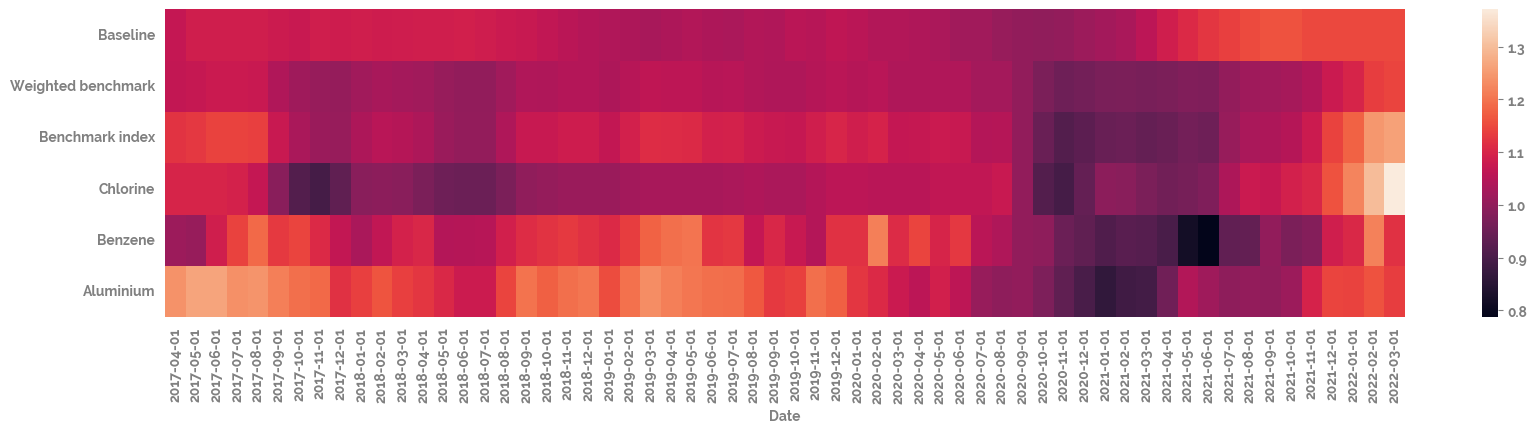

In [9]:
_ = plt.figure(figsize=(20, 4))
_ = sns.heatmap(df
                # .drop(target, axis=1)
                .T
)

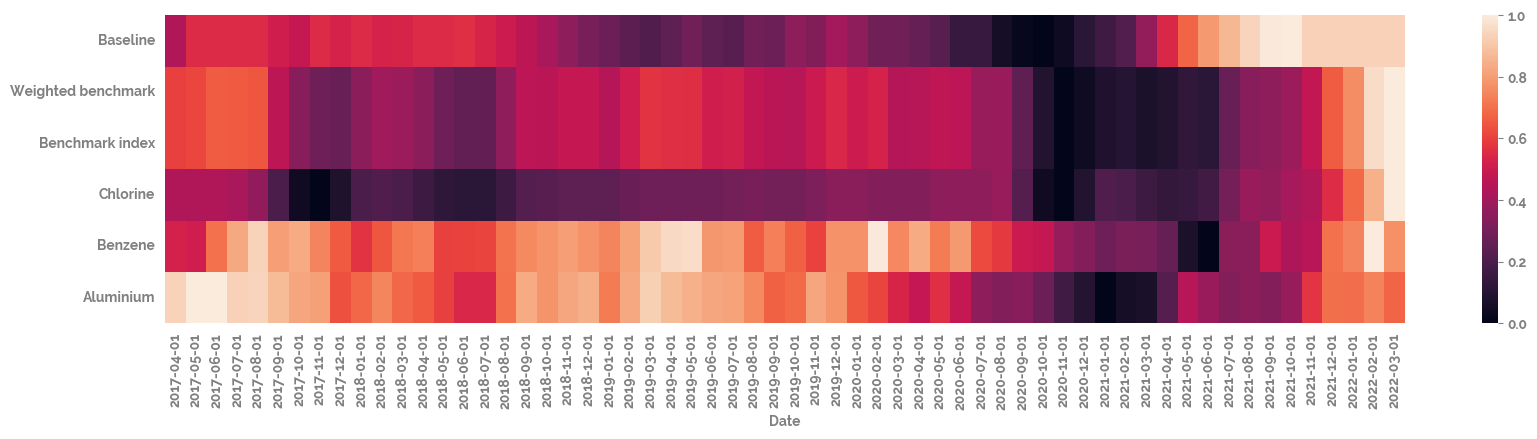

In [10]:
_ = plt.figure(figsize=(20, 4))
_ = sns.heatmap(df
                # .drop(target, axis=1)
                .pipe(apply_scaling)
                .T)

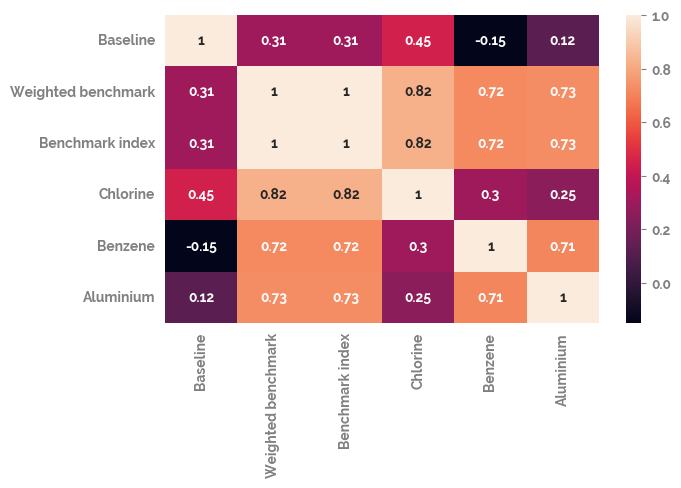

In [11]:
_ = plt.figure(figsize=(7, 4))
_ = sns.heatmap(df.corr(), annot=True)

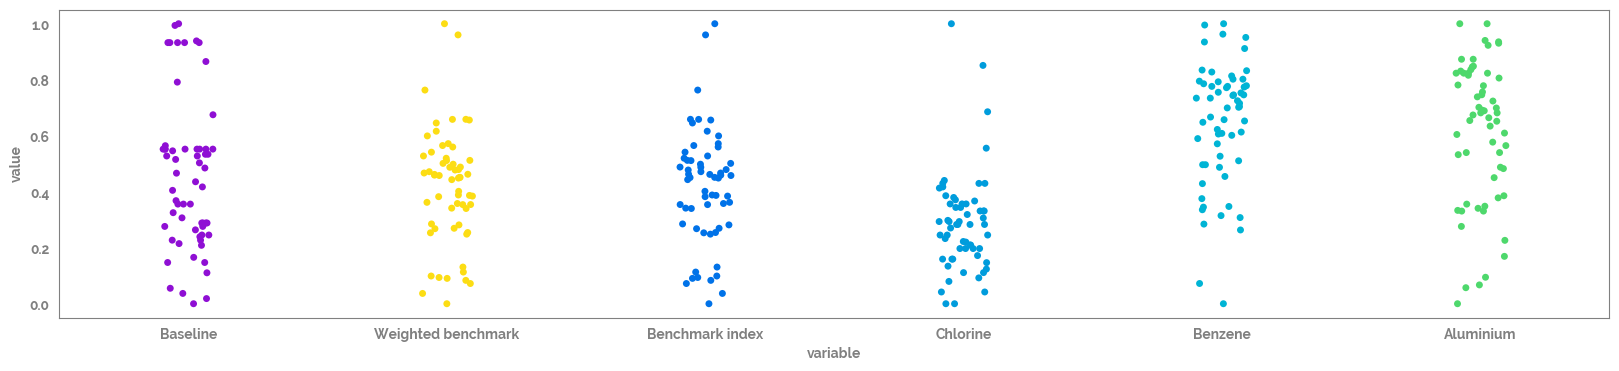

In [12]:
_ = plt.figure(figsize=(20, 4))
_ = sns.stripplot(data=df
                .pipe(apply_scaling, "MinMax")
                # .reset_index()
                .melt(),
                x = "variable",
                y = "value",
                )

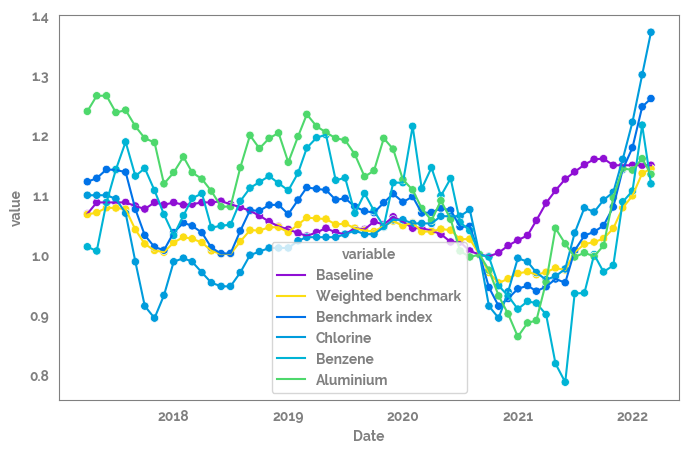

In [13]:
_ = plt.figure(figsize=(8, 5))
_ = sns.lineplot(data=df
                .reset_index()
                .melt(id_vars="Date"),
                x="Date",
                y="value",
                hue="variable"
                )

_ = sns.scatterplot(data=df
                .reset_index()
                .melt(id_vars="Date"),
                x="Date",
                y="value",
                hue="variable",
                legend=False
                )

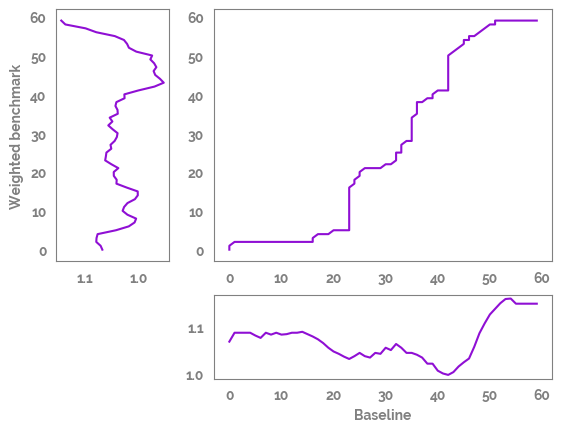

In [14]:
feature_1 = "Baseline"
feature_2 = "Weighted benchmark"
query = df[feature_1].values
template = df[feature_2].values

## Find the best match with the canonical recursion formula
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
_ = alignment.plot(type="threeway", xlab=feature_1,
    ylab=feature_2)

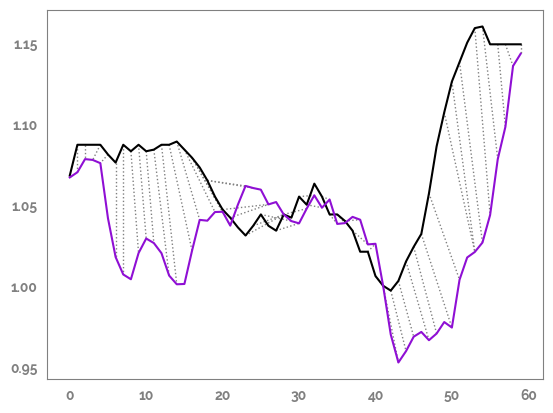

In [15]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
_ = dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=0)

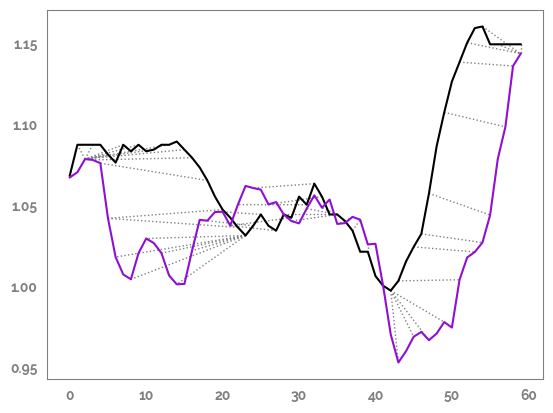

In [16]:
_ = alignment.plot(type="twoway")

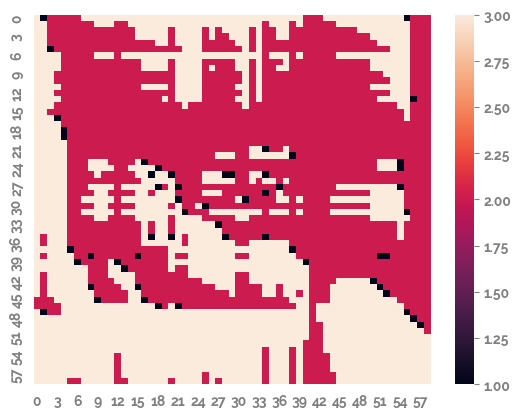

In [17]:
_ = sns.heatmap(alignment.directionMatrix[1:, 1:])

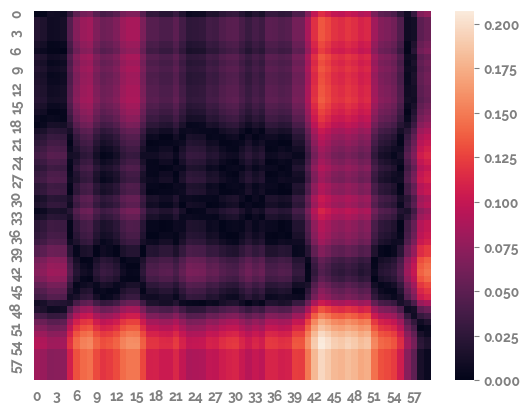

In [18]:
_ = sns.heatmap(alignment.localCostMatrix)

In [19]:
alignment.localCostMatrix.min(), alignment.localCostMatrix.max()

(0.0, 0.20734999999999992)

In [20]:
alignment.distance

0.9582500000000015

In [21]:
X = df.drop(target,axis=1)
y = df[target]

In [22]:
mod = RandomForestRegressor(random_state=42)
# mod = LinearRegression(fit_intercept=True)

In [23]:
_ = mod.fit(X, y)
y_pred = mod.predict(X)
df_test = pd.DataFrame({"y_pred": y_pred, target: y})

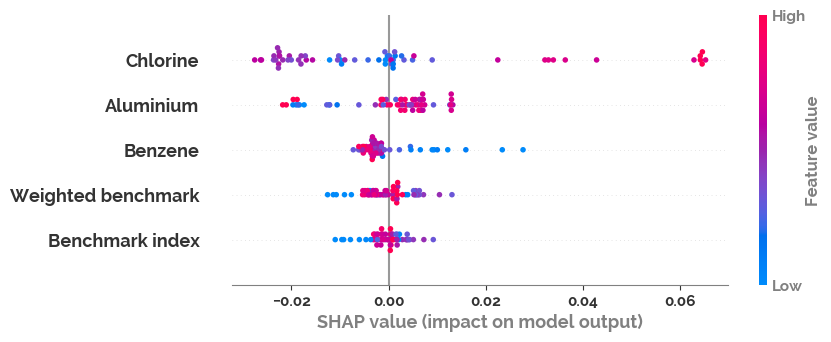

In [24]:
if mod.__class__.__name__ != "LinearRegression":
    explainer = shap.Explainer(mod)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)

In [25]:
dict_results = correlation_analysis(data=df_test, 
                     col_list=["y_pred"], 
                     row_list=[target], 
                     check_norm=True, 
                     method = 'pearson', 
                     dropna = 'pairwise')
cors_df=dict_results["summary"]

r_value = cors_df["r-value"].values[0].round(3)
p_value = cors_df["p-value"].values[0].round(3)
if p_value < 0.001:
    p_value = "< 0.001"
n = cors_df["N"].values[0].round(3)

cors_df

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Pearson,y_pred,Baseline,0.964303,3.655245e-35,True,60


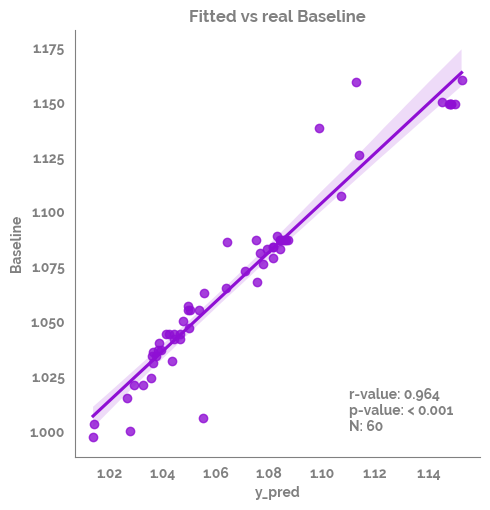

In [26]:
_ = sns.lmplot(data=df_test,
               x="y_pred",
               y=target)
_ = plt.annotate(text=f"r-value: {r_value}\np-value: {p_value}\nN: {n}", xy=(1.11,1))
_ = plt.title(f"Fitted vs real {target}")

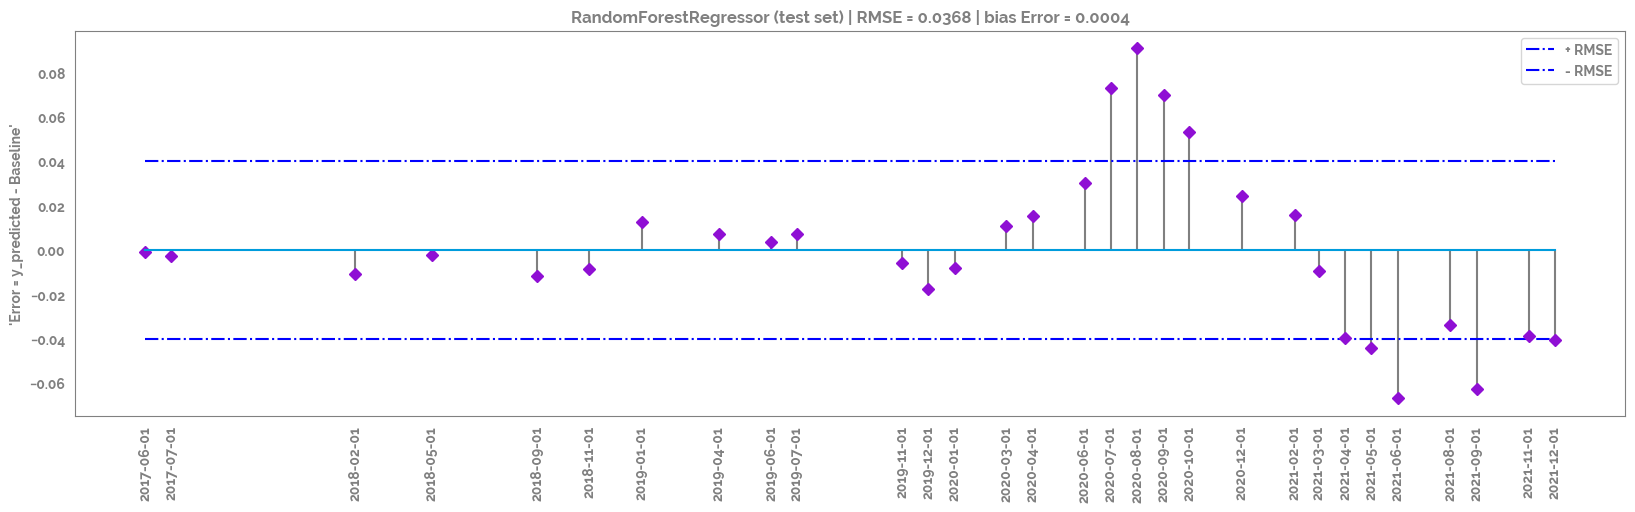

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Pearson,y_pred,Baseline,0.595976,0.000511,True,30


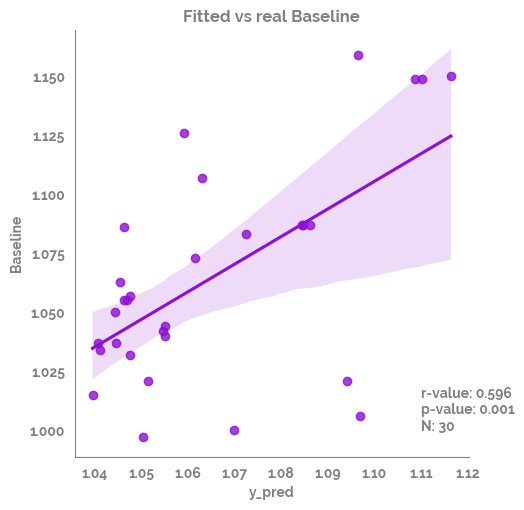

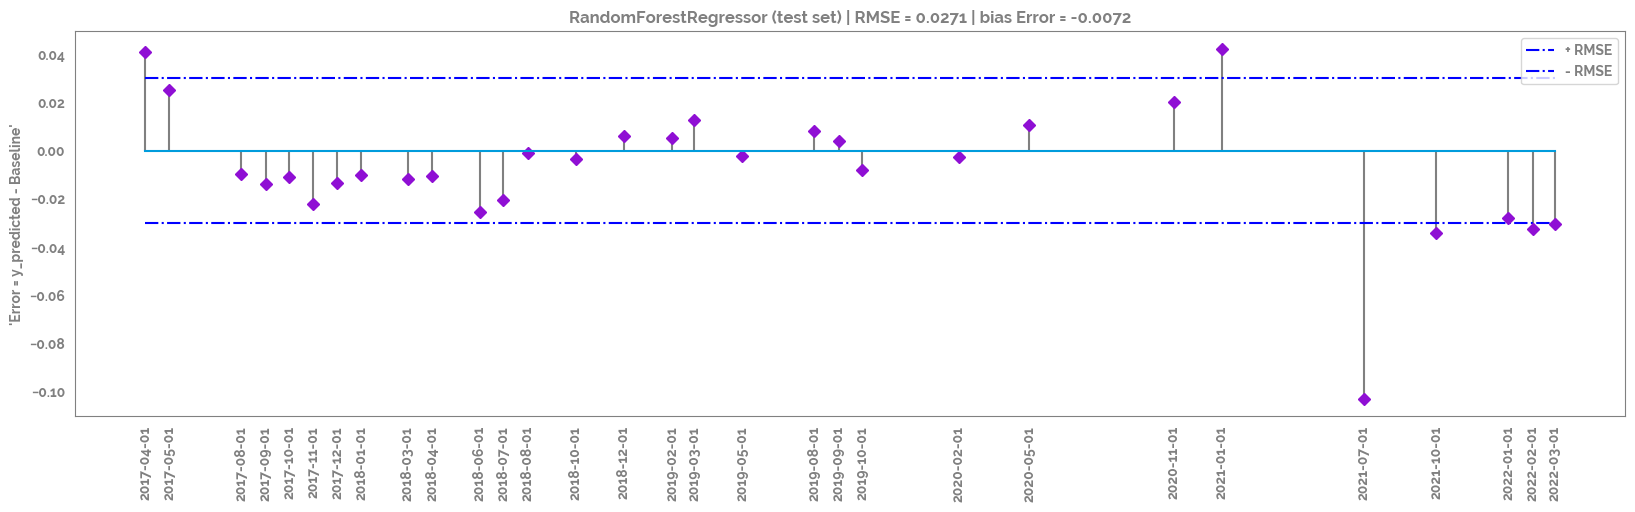

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Pearson,y_pred,Baseline,0.75346,0.000002,True,30


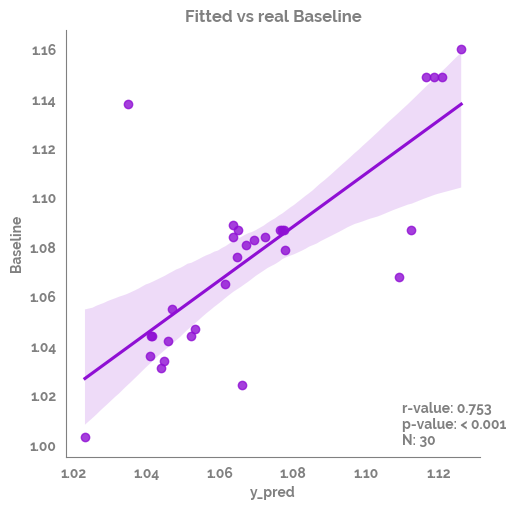

In [27]:
kfold = KFold(n_splits=2, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.iloc[train_ix, :], X.iloc[test_ix, :]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
    
    _ = mod.fit(X = train_X, 
                y = train_y)
    
    y_pred = mod.predict(test_X)

    df_test = pd.DataFrame({"y_pred": y_pred, target: test_y})

    user_ids_first = df_test.head(1).index.tolist()[0]
    user_ids_last = df_test.tail(1).index.tolist()[0]

    _ = plt.figure(figsize=(20,5))
    _ = plt.title(f"{mod.__class__.__name__} (test set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[target]), 4)}")
    rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[target], use_line_collection=True, linefmt='grey', markerfmt='D')
    _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='+ RMSE', 
                    xmin = user_ids_first, 
                    xmax = user_ids_last
                    ) 
    _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[target])),2), colors='b', linestyles='-.', label='- RMSE', 
                    xmin = user_ids_first, 
                    xmax = user_ids_last
                    ) 
    _ = plt.xticks(rotation=90, ticks=df_test.index)
    _ = plt.ylabel(f"'Error = y_predicted - {target}'")
    _ = plt.legend()
    _ = plt.show()

    dict_results = correlation_analysis(data=df_test, 
                     col_list=["y_pred"], 
                     row_list=[target], 
                     check_norm=True, 
                     method = 'pearson', 
                     dropna = 'pairwise')
    cors_df=dict_results["summary"]

    r_value = cors_df["r-value"].values[0].round(3)
    p_value = cors_df["p-value"].values[0].round(3)
    if p_value < 0.001:
        p_value = "< 0.001"
    n = cors_df["N"].values[0].round(3)

    display(cors_df)

    _ = sns.lmplot(data=df_test,
               x="y_pred",
               y=target)
    _ = plt.annotate(text=f"r-value: {r_value}\np-value: {p_value}\nN: {n}", xy=(1.11,1))
    _ = plt.title(f"Fitted vs real {target}")
    _ = plt.show()